In [2]:
## For debbugging
%load_ext autoreload

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

import textacy
import os
import codecs
import sys

from unicodedata import normalize

In [4]:
%aimport mlp.tools
%autoreload 1
from mlp.tools import *

In [21]:
data_directory = os.path.join('.', 'data/hvac_data')
raw_excel_filepath = os.path.join(data_directory,
                                   'hvac_mslips_20170720.xlsx')
raw_txt_filepath = os.path.join(data_directory,
                                   'raw_txt_HVAC.txt')
bigram_logs_filepath = os.path.join(data_directory,
                                   'bigram_csv_HVAC.csv')
raw_csv_filepath = os.path.join(data_directory,
                                   'raw_csv_HVAC.csv')

if not os.path.isfile(raw_csv_filepath): 
    relevant_cols = [5,248,6,7,10,43,11,44]
    names = ['Description','Resolution', 
             'AssetID', 'Location', 
             'Assigned', 'Reported',
             'SolveDate', 'ReportDate']
#     np.argsort(relevant_cols)
#     pd.DataFrame()
    df = pd.read_excel(raw_excel_filepath, header=1, encoding='utf-8', 
                       names=[names[i] for i in np.argsort(relevant_cols)], 
                       parse_cols=relevant_cols)

    df.Description = df.Description.fillna('').apply(lambda x: x.replace('\n',' '))
    df.Resolution = df.Resolution.fillna('').apply(lambda x: x.replace('\n',' '))
    print(df[['Description','Resolution']].head())
    # df['RawText'] = df.Description.astype(str).str.cat(df.Resolution.astype(str, errors='ignore'), sep='. ')
    df["RawText"] = df[['Description','Resolution']].apply(lambda x: '. '.join(x), axis=1)



    df['RawText'].to_csv(raw_txt_filepath, sep='\t', index=False)

    bigram_docs(raw_txt_filepath, bigram_logs_filepath, 
                 data_directory=data_directory, special={'Action Taken:': ''})

    df['RawText'] = pd.read_csv(bigram_logs_filepath, sep='\t')
    df.head()

    df[['Building', 'Room']] = df.Location.str.split('-', expand=True, n=1)
    df['AssetID'] = df.AssetID.str.split(' ', expand=True, n=1)[1]
    df = df[['RawText', 
             'AssetID', 'Building', 'Room',
             'Assigned', 'Reported',
             'SolveDate', 'ReportDate']].dropna(subset=['RawText'])


    # if not os.path.isfile(raw_csv_filepath): 
    df.to_csv(raw_csv_filepath, header=False, encoding='utf-8')

else:
    df = pd.read_csv(raw_csv_filepath, names=['RawText', 
                                              'AssetID', 'Building', 'Room',
                                              'Assigned', 'Reported',
                                              'SolveDate', 'ReportDate'])

In [23]:
docs = textacy.fileio.read.read_csv(raw_csv_filepath, encoding='utf-8')

content_stream, metadata_stream = textacy.fileio.split_record_fields(docs, 1)  # Descriptions in Col 1
corpus = textacy.Corpus(u'en', texts=content_stream, metadatas=metadata_stream)

In [24]:
# doc_term_matrix, id2term = textacy.vsm.doc_term_matrix(
#             (doc.to_terms_list(ngrams=(1,2,3), 
#                                normalize=False,
#                                named_entities=False, 
# #                                filter_stops=True,  # Nope! Not needed :)
#                                filter_punct=False,
#                                as_strings=True)
#                 for doc in corpus),
#             weighting='tfidf', 
#             normalize=False, 
#             smooth_idf=False, 
#             min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs

# topn = 2500
# topn_tok = [id2term[i] for i in doc_term_matrix.sum(axis=0).argsort()[0,-topn:].tolist()[0][::-1]]
# with open('HVAC_top{}.txt'.format(topn), 'w') as f:
#     for i in topn_tok:
#         try:
#             f.write(i+'\n')
#         except UnicodeEncodeError:
#             print(i, '-->', normalize('NFKD', i).encode('ascii','ignore'))
#             f.write(normalize('NFKD', i).encode('ascii','ignore') +'\n')

In [25]:
vocab_filepath = os.path.join(data_directory, 'hvac_vocab.csv')
# read in the keyword dictionary and to some data-munging. 
df_vocab = pd.read_csv(vocab_filepath, header=0, encoding='utf-8',
                       names = ['token', 'NE','alias','note'], index_col=0, na_values=['nan'], usecols=[1,2,3,4])
df_vocab = df_vocab.dropna(subset=['NE'])  # remove named entities that are NaN
df_vocab.alias = df_vocab.apply(lambda x: np.where(pd.isnull(x.alias), x.name, x.alias), axis=1) # alias to original if blank
df_vocab = df_vocab[~df_vocab.index.duplicated(keep='first')]


In [26]:
# how many instances of each keyword class are there?
print('named entities: ')
print('I\tItem\nP\tProblem\nS\tSolution\nR\tRedundant')
print('U\tUnknown\nX\tStop Word')
df_vocab.groupby('NE').nunique()
# pd.groupby.

named entities: 
I	Item
P	Problem
S	Solution
R	Redundant
U	Unknown
X	Stop Word


,NE,alias,note
NE,,,
I,1,311,18
P,1,46,1
R,1,10,2
S,1,50,2
U,1,17,6
X,1,84,3


In [27]:
def get_norm_tokens(doc_n, doc_term_mat, id2term):
    doc = doc_term_mat[doc_n].toarray()
    return [id2term[i] for i in doc.nonzero()[1]]

# def doc_to_tags(tokens, thes):
    # #     tokens = get_norm_terms(doc)
    #     tags = {'I':[], 'P':[], 'S':[]}
    #     untagged = []
    #     vocab_list = thes.index.tolist()
    #     for tok_phrase in tokens:

    #         if  tok_phrase in vocab_list: # recognized token/s?
    #             typ = thes.loc[tok_phrase]['NE']

    #             if typ in tags.keys():  #  I, P, or S?
    #                 tags[typ] += list(set(tags[typ] + [thes.loc[tok_phrase]['alias'].tolist()]))
    #             elif typ is "U":  
    #                 # new! added way to check for unknowns/human-input needed on a issue-lvl
    #                 untagged += [tok_phrase]
    #             else:  # R or X?
    #                 pass # skip'em

    #             tok_list = re.split("\W+|_",tok_phrase)
    #             for tok in tok_list:
    #                 if  tok in vocab_list:  # recognized token/s?
    #                     typ = thes.loc[tok]['NE']

    #                     if typ in tags.keys():  #  I, P, or S?
    #                         tags[typ] += list(set(tags[typ] + [thes.loc[tok]['alias'].tolist()]))
    #                     else:  # R or X?
    #                         pass # skip'em
    #         elif np.any([i in vocab_list for i in tok.split(' ')]):
    #             # If any subset of n-gram `tok` is itself a recognized token, skip'em
    #             # catches fluff
    #             pass
    #         else: # not recognized :(
    #             untagged += [tok]
    #     return tags, list(set(untagged))
        

        
def doc_to_tags(tokens, thes):
#     tokens = get_norm_terms(doc)
    tags = {'I':[], 'P':[], 'S':[]}
    untagged = []
    vocab_list = thes.index.tolist()
    for tok in tokens:
        if tok in vocab_list:  # recognized token?
            typ = thes.loc[tok]['NE']
            
            if typ in tags.keys():  #  I, P, or S?
                tags[typ] = list(set(tags[typ] + [thes.loc[tok]['alias'].tolist()]))
            else:  # R or X?
                pass # skip'em
        elif np.any([i in vocab_list for i in tok.split(' ')]):
            # If any subset of `tok` is itself a recognized token, skip'em
            pass
        else: # not recognized :(
            untagged += [tok]
    return tags, list(set(untagged))
            
def tag_corpus(corpus, thes):
    RT, I, S, P, UK = ([], [], [], [], [])
    
    # make the tf-idf embedding to tokenize with lemma/ngrams
    doc_term_matrix, id2term = textacy.vsm.doc_term_matrix(
            (doc.to_terms_list(ngrams=(1,2,3), 
                               normalize=u'lemma',
                               named_entities=False, 
#                                filter_stops=True,  # Nope! Not needed :)
                               filter_punct=True,
                               as_strings=True)
                for doc in corpus),
            weighting='tfidf', 
            normalize=False, 
            smooth_idf=False, 
            min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs

    # iterate over all issues
    for  doc_n, doc in enumerate(tqdm_notebook(corpus)):
        tokens = get_norm_tokens(doc_n, doc_term_matrix, id2term)
        tags, unknown = doc_to_tags(tokens, thes)
        UK += [', '.join(unknown)]
        RT += [doc.text]
        I += [', '.join(tags['I'])]
        S += [', '.join(tags['S'])]
        P += [', '.join(tags['P'])]
    # get back a tagged DF
    return pd.DataFrame(data={
        'RawText': RT,
        'Items': I,
        'Problem': P,
        'Solution': S,
        'UK_tok': UK  # unknown
    }, columns = ['RawText','Items','Problem','Solution','UK_tok'])

df_pred = tag_corpus(corpus, df_vocab)
df_pred.head(10)

Widget Javascript not detected.  It may not be installed or enabled properly.


,RawText,Items,Problem,Solution,UK_tok
0,adjust repai replace freeze_stat reset poc_ed,freeze_stat,,"reset, replace, adjust","repai, poc_ed"
1,reset adjust repair freeze_stat restart poc_ed,freeze_stat,,"restart, reset, repair, adjust",poc_ed
2,rset adjust repair freeze_stat reset_freezestat,freeze_stat,,"repair, adjust",reset_freezestat
3,reset adjust repair freeze_stat reset_alarm hv...,freeze_stat,,"reset, repair, adjust","hv-3, hv-2"
4,failure computer room alarm check system -PRON...,"room, computer, 71F, temperature, 2F, set_poin...","alarm, failure, low, no_problem",check,"=, -pron-, hunmidity, 30%"
5,reset adjust repair freeze_stat reset restart ...,freeze_stat,,"restart, reset, repair, adjust",poc_ed
6,high_humidity room 935 check humidity find iss...,"room, humidity",check_request,"find, check, replace","high_humidity, meter, 935, -pron-, personal"
7,reset adjust repair freeze_stat restart unit p...,"unit, freeze_stat",,"restart, reset, repair, adjust",poc_ed
8,rm b185 heat reggie stroke operator make_sure ...,"65F, heat, 69F, space_temperature",,"find, adjust","proper_operation, measure, reggie, operator, s..."
9,too_cold b-214 b-220 room temperature cold due...,"room, acu-8, temperature",too_cold,"repair, is_cause_of","b-220, poc_stephanie, shop_02, b-214"


In [28]:
df_pred[df_pred.UK_tok ==''].shape[0]

1003

In [29]:
print(df_pred[(df_pred[['Items','Problem','Solution']]=='').all(axis=1)].shape[0])
df_pred[(df_pred[['Items','Problem','Solution']]=='').all(axis=1)]

35


,RawText,Items,Problem,Solution,UK_tok
39,cold a004 a005 fr bateman x5580,,,,"fr, a005, a004"
260,fabricate_metal access cover 28 x 38 1/2 hem f...,,,,"metal, 28, 38, access, fabricated metal, fabri..."
355,wet_carpet rm 114,,,,"114, wet_carpet"
616,b349-mod-345b b367-mod-363b a368-mod-362b,,,,
631,cut_hole latch plate const_shop cut_hole latch...,,,,"latch plate const_shop, cut_hole, plate const_..."
742,a_wing hot,,,,a_w
875,humidty high b331,,,,"b331, humidty"
897,air_conditioner whistle_noise a259,,,,"air_conditioner, whistle_noise, a259"
1159,return blow pull 117 action_take reverse_rotat...,,,,"117, work_properly, reverse_rotation, e_fan, p..."
1575,north_side exterior air_intake cover plate damage,,,,"north_side, air_intake, damage, exterior air_i..."


In [30]:
# save everything to disk
df_pred.to_excel('hvac_tagged.xlsx')

In [ ]:
from itertools import chain
from sklearn.preprocessing import MultiLabelBinarizer

def get_relevant(df, col, topn=20):
    
    tags = [x[1][col].split(', ') for x in df.iterrows()]
    binner = MultiLabelBinarizer().fit(tags)
    vecs = binner.transform(tags)
    counts = vecs.sum(axis=0)
    relevant = [(binner.classes_[i], counts[i], vecs[:,i]) for i in counts.argsort()[-topn:][::-1]]
    return relevant

relevant = get_relevant(df_pred, 'Items', topn=100) +\
get_relevant(df_pred, 'Problem', topn=20) +\
get_relevant(df_pred, 'Solution', topn=10)
print('e.g. ...')
relevant[:10]

In [31]:
event_df = pd.DataFrame(columns = [i[0] for i in relevant if i[0]!=u''], 
             data = np.array([i[2] for i in relevant if i[0]!=u'']).T)
# plt.barh()
event_df.head(10)

,room,poc,temperature,building,thermostat,unit,air_conditioning_unit,air,customer,valve,...,down,replace,adjust,check,find,verify,calibrate,repair,reset,set
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
6,1,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,0
7,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
9,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
og_data = df.set_index(['ReportDate'])
event_df.index = og_data.index
event_df.index = pd.to_datetime(event_df.index, errors='coerce')
event_df.head()

,room,poc,temperature,building,thermostat,unit,air_conditioning_unit,air,customer,valve,...,down,replace,adjust,check,find,verify,calibrate,repair,reset,set
ReportDate,,,,,,,,,,,,,,,,,,,,,
2009-02-12 14:44:55,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
2009-02-15 23:25:01,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
2009-02-17 04:20:08,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2009-02-17 04:22:38,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
2009-02-17 04:26:15,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [36]:
"""
Calendar heatmaps from Pandas time series data.
Plot Pandas time series data sampled by day in a heatmap per calendar year,
similar to GitHub's contributions calendar.

adapted from:
    'Martijn Vermaat' 14 Feb 2016
    'martijn@vermaat.name'
    'https://github.com/martijnvermaat/calmap'
"""
from __future__ import unicode_literals

import calendar
import datetime

from matplotlib.colors import ColorConverter, ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from distutils.version import StrictVersion

_pandas_18 = StrictVersion(pd.__version__) >= StrictVersion('0.18')


def yearplot(data, year=None, how='sum', vmin=None, vmax=None, cmap='Reds',
             fillcolor='whitesmoke', linewidth=1, linecolor=None,
             daylabels=calendar.day_abbr[:], dayticks=True,
             monthlabels=calendar.month_abbr[1:], monthticks=True, ax=None,
             **kwargs):
    """
    Plot one year from a timeseries as a calendar heatmap.
    Parameters
    ----------
    data : Series
        Data for the plot. Must be indexed by a DatetimeIndex.
    year : integer
        Only data indexed by this year will be plotted. If `None`, the first
        year for which there is data will be plotted.
    how : string
        Method for resampling data by day. If `None`, assume data is already
        sampled by day and don't resample. Otherwise, this is passed to Pandas
        `Series.resample`.
    vmin, vmax : floats
        Values to anchor the colormap. If `None`, min and max are used after
        resampling data by day.
    cmap : matplotlib colormap name or object
        The mapping from data values to color space.
    fillcolor : matplotlib color
        Color to use for days without data.
    linewidth : float
        Width of the lines that will divide each day.
    linecolor : color
        Color of the lines that will divide each day. If `None`, the axes
        background color is used, or 'white' if it is transparent.
    daylabels : list
        Strings to use as labels for days, must be of length 7.
    dayticks : list or int or bool
        If `True`, label all days. If `False`, don't label days. If a list,
        only label days with these indices. If an integer, label every n day.
    monthlabels : list
        Strings to use as labels for months, must be of length 12.
    monthticks : list or int or bool
        If `True`, label all months. If `False`, don't label months. If a
        list, only label months with these indices. If an integer, label every
        n month.
    ax : matplotlib Axes
        Axes in which to draw the plot, otherwise use the currently-active
        Axes.
    kwargs : other keyword arguments
        All other keyword arguments are passed to matplotlib `ax.pcolormesh`.
    Returns
    -------
    ax : matplotlib Axes
        Axes object with the calendar heatmap.
    Examples
    --------
    By default, `yearplot` plots the first year and sums the values per day:
    .. plot::
        :context: close-figs
        calmap.yearplot(events)
    We can choose which year is plotted with the `year` keyword argment:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, year=2015)
    The appearance can be changed by using another colormap. Here we also use
    a darker fill color for days without data and remove the lines:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, cmap='YlGn', fillcolor='grey',
                        linewidth=0)
    The axis tick labels can look a bit crowded. We can ask to draw only every
    nth label, or explicitely supply the label indices. The labels themselves
    can also be customized:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, monthticks=3, daylabels='MTWTFSS',
                        dayticks=[0, 2, 4, 6])
    """
    if year is None:
        year = data.index.sort_values()[0].year

    if how is None:
        # Assume already sampled by day.
        by_day = data
    else:
        # Sample by day.
        if _pandas_18:
            by_day = data.resample('W').agg(how)
        else:
            by_day = data.resample('W', how=how)
    
    
    # Min and max per day.
    if vmin is None:
        vmin = by_day.min().min()
    if vmax is None:
        vmax = by_day.max().max()

    if ax is None:
        ax = plt.gca()

    if linecolor is None:
        # Unfortunately, linecolor cannot be transparent, as it is drawn on
        # top of the heatmap cells. Therefore it is only possible to mimic
        # transparent lines by setting them to the axes background color. This
        # of course won't work when the axes itself has a transparent
        # background so in that case we default to white which will usually be
        # the figure or canvas background color.
        #linecolor = ax.get_axis_bgcolor()
        linecolor = ax.get_facecolor()

        if ColorConverter().to_rgba(linecolor)[-1] == 0:
            linecolor = 'white'
    
    # Filter on year.
    by_day = by_day[by_day.index.year==year]
    dat_names = by_day.columns
    
    pd.options.mode.chained_assignment = None  # default='warn'
    by_day['week'] = by_day.index.week
    
    # Add missing days.
    by_day = by_day.reindex(
        pd.date_range(start=str(year), end=str(year + 1), freq='W')[:-1])
    # There may be some days assigned to previous year's last week or
    # next year's first week. We create new week numbers for them so
    # the ordering stays intact and week/day pairs unique.
    by_day.loc[(by_day.index.month == 1) & (by_day.week > 50), 'week'] = 0
    by_day.loc[(by_day.index.month == 12) & (by_day.week < 10), 'week'] \
        = by_day.week.max() + 1
    
    plot_data = by_day[dat_names].transpose().fillna(0)

    # Draw heatmap.
    kwargs['linewidth'] = linewidth
    kwargs['edgecolors'] = linecolor
    ax.pcolormesh(plot_data,
                  #vmin=vmin, vmax=vmax, 
                  cmap=cmap, **kwargs)
    # Limit heatmap to our data.
    ax.set(xlim=(0, plot_data.shape[1]), ylim=(0, plot_data.shape[0]))

    # Square cells.
    ax.set_aspect('equal')

    # Remove spines and ticks.
    for side in ('top', 'right', 'left', 'bottom'):
        ax.spines[side].set_visible(False)
    ax.xaxis.set_tick_params(which='both', length=0)
    ax.yaxis.set_tick_params(which='both', length=0)

    # Get indices for monthlabels.
    if monthticks is True:
        monthticks = range(len(monthlabels))
    elif monthticks is False:
        monthticks = []
    elif isinstance(monthticks, int):
        monthticks = range(len(monthlabels))[monthticks // 2::monthticks]

        
    ax.set_xlabel('')
    #ax.set_xticks([by_day.ix[datetime.date(year, i + 1, 15)].week for i in monthticks])
    
    ax.set_xticks([pd.Timestamp('{}/15/{}'.format(i, year)).week-1.5 for i in range(1,13)])
    ax.set_xticklabels([monthlabels[i] for i in monthticks], ha='center')
    

    ax.set_ylabel('')
    ax.yaxis.set_ticks_position('right')
    ax.set_yticks([dat_names.shape[0] - i - .5  for i in range(dat_names.shape[0])])
    ax.set_yticklabels(dat_names[::-1], rotation='horizontal',
                       va='center')

    return ax

def calendarplot(data, how='sum', yearlabels=True, yearascending=True, yearlabel_kws=None,
                 subplot_kws=None, gridspec_kws=None, fig_kws=None, **kwargs):
    """
    Plot a timeseries as a calendar heatmap.
    Parameters
    ----------
    data : Series
        Data for the plot. Must be indexed by a DatetimeIndex.
    how : string
        Method for resampling data by day. If `None`, assume data is already
        sampled by day and don't resample. Otherwise, this is passed to Pandas
        `Series.resample`.
    yearlabels : bool
       Whether or not to draw the year for each subplot.
    yearascending : bool
       Sort the calendar in ascending or descending order.
    yearlabel_kws : dict
       Keyword arguments passed to the matplotlib `set_ylabel` call which is
       used to draw the year for each subplot.
    subplot_kws : dict
        Keyword arguments passed to the matplotlib `add_subplot` call used to
        create each subplot.
    gridspec_kws : dict
        Keyword arguments passed to the matplotlib `GridSpec` constructor used
        to create the grid the subplots are placed on.
    fig_kws : dict
        Keyword arguments passed to the matplotlib `figure` call.
    kwargs : other keyword arguments
        All other keyword arguments are passed to `yearplot`.
    Returns
    -------
    fig, axes : matplotlib Figure and Axes
        Tuple where `fig` is the matplotlib Figure object `axes` is an array
        of matplotlib Axes objects with the calendar heatmaps, one per year.
    Examples
    --------
    With `calendarplot` we can plot several years in one figure:
    .. plot::
        :context: close-figs
        calmap.calendarplot(events)
    """
    yearlabel_kws = yearlabel_kws or {}
    subplot_kws = subplot_kws or {}
    gridspec_kws = gridspec_kws or {}
    fig_kws = fig_kws or {}

    years = np.unique(data.index.year)
    if not yearascending:
        years = years[::-1]

    fig, axes = plt.subplots(nrows=len(years), ncols=1, squeeze=False,
                             subplot_kw=subplot_kws,
                             gridspec_kw=gridspec_kws, **fig_kws)
    axes = axes.T[0]

    # We explicitely resample by day only once. This is an optimization.
    if how is None:
        by_day = data
    else:
        if _pandas_18:
            by_day = data.resample('W').agg(how)
        else:
            by_day = data.resample('W', how=how)
        # normalize to unit norm
    by_day = by_day/np.sqrt(np.square(by_day).sum(axis=0))
    
    ylabel_kws = dict(
        fontsize=32,
        color=kwargs.get('fillcolor', 'xkcd:wheat'),
        fontweight='bold',
        fontname='Arial',
        ha='center')
    ylabel_kws.update(yearlabel_kws)

    max_weeks = 0

    for year, ax in zip(years, axes):
        yearplot(by_day, year=year, how=None, ax=ax, **kwargs)
        max_weeks = max(max_weeks, ax.get_xlim()[1])

        if yearlabels:
            ax.set_ylabel(str(year), **ylabel_kws)

    # In a leap year it might happen that we have 54 weeks (e.g., 2012).
    # Here we make sure the width is consistent over all years.
    for ax in axes:
        ax.set_xlim(0, max_weeks)

    # Make the axes look good.
    plt.tight_layout()

    return fig, axes


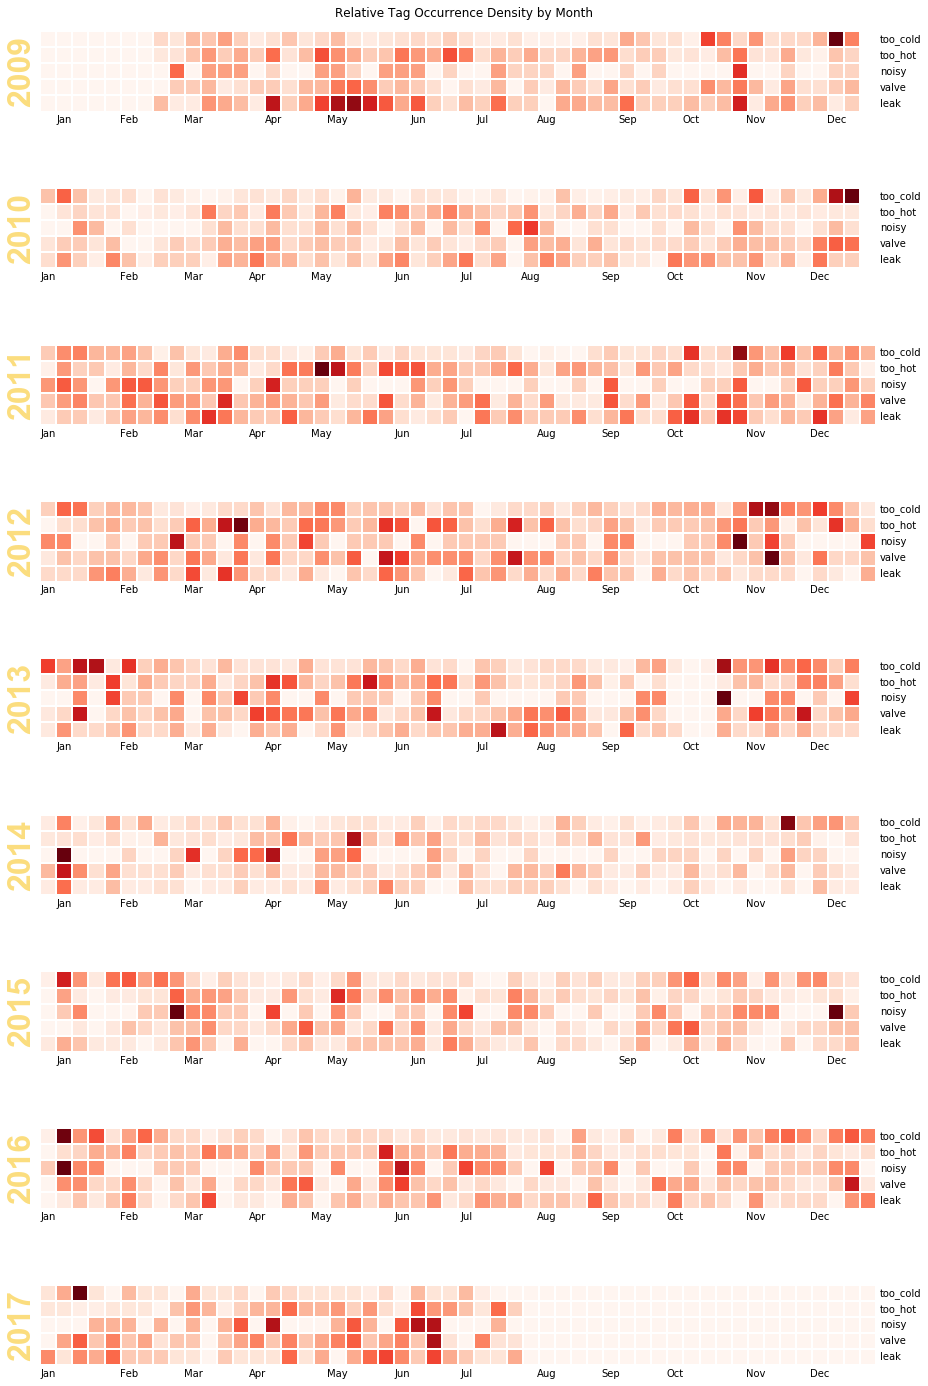

In [37]:
calendarplot(event_df[['leak',
                       'valve',
                       'noisy',
                       'too_hot',
                       'too_cold'
                       ]],
             how='sum', fig_kws={'figsize':(13,20)});
plt.suptitle('Relative Tag Occurrence Density by Month')

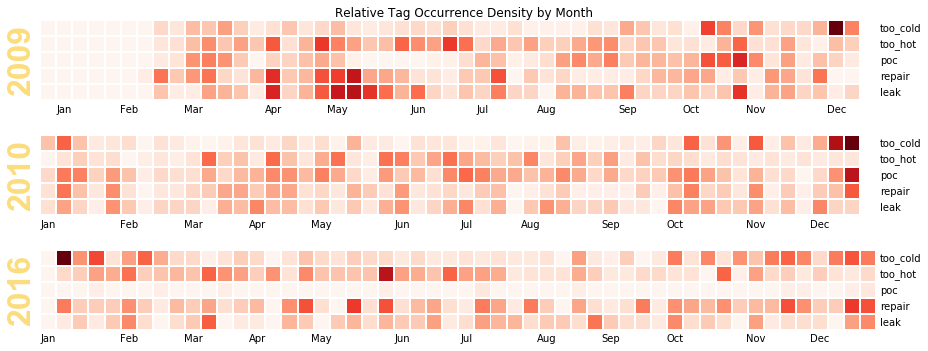

In [38]:
calendarplot(event_df[['leak',
                       'repair',
                       'poc',
                       'too_hot',
                       'too_cold'
                       ]][event_df.index.year.isin([2009, 2010, 2016])],
             how='sum', fig_kws={'figsize':(13,5)});
plt.suptitle('Relative Tag Occurrence Density by Month')

In [39]:
event_df[event_df.poc==1].sum().to_frame(name='Customer_POC').sort_values('Customer_POC', 
                                                                                   ascending=False).iloc[:20] 


,Customer_POC
poc,3074
room,993
adjust,936
customer,840
too_hot,767
replace,737
find,736
too_cold,706
thermostat,705
building,617


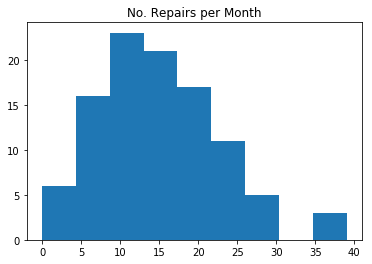

In [40]:
week_df = event_df.resample('M').agg(sum).fillna(0)
plt.hist(week_df['repair'].values, bins='auto')
plt.title('No. Repairs per Month')

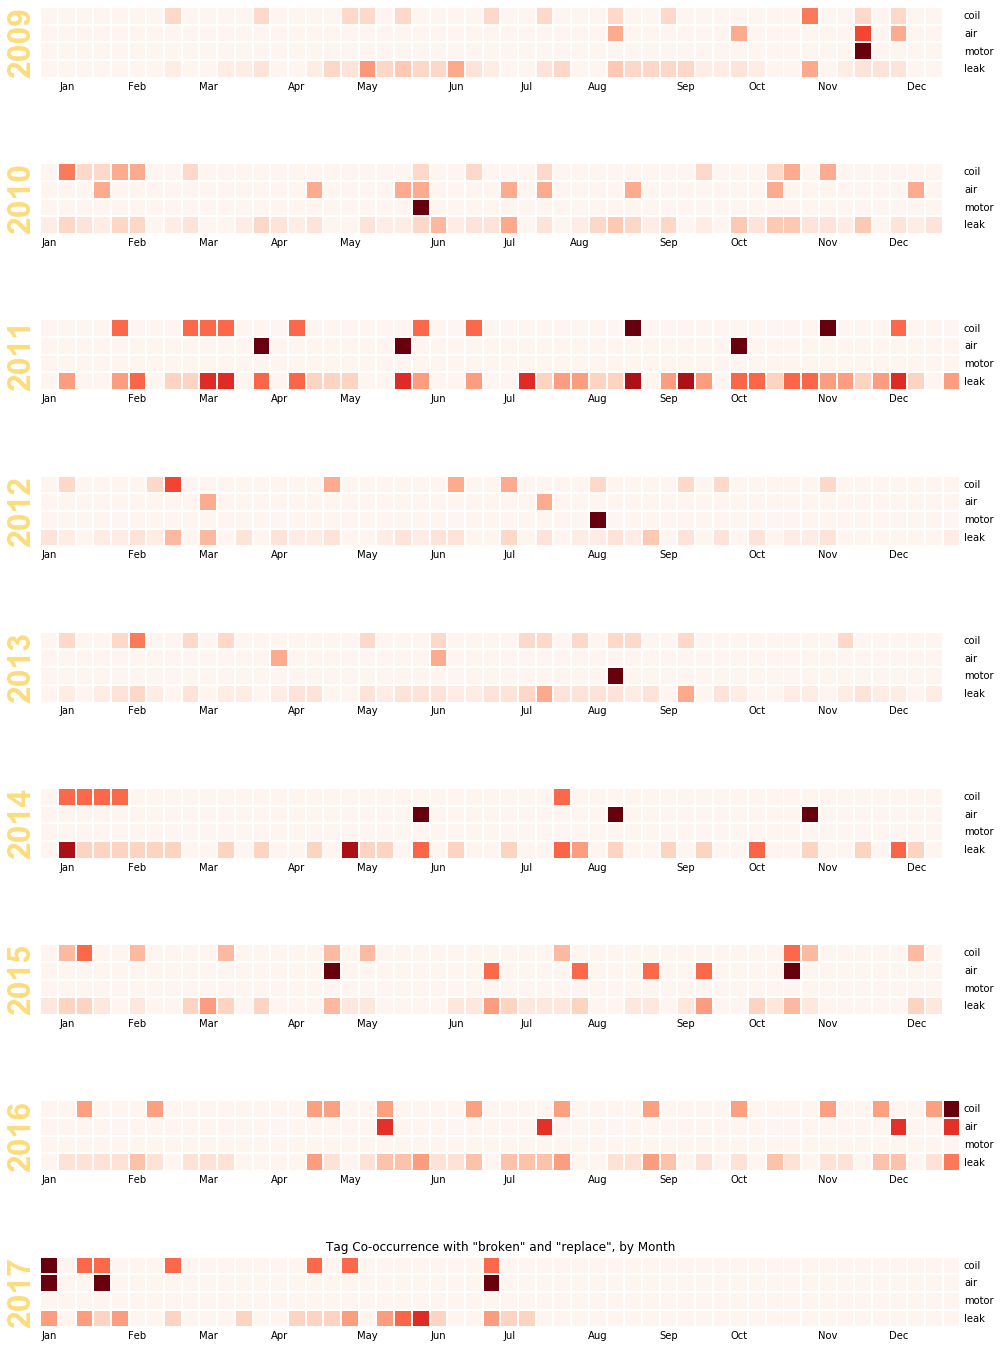

In [41]:
weekly_replace = event_df[(event_df['leak']==1) &\
                          ((event_df['motor']==1)|\
                           (event_df['coil']==1)|\
                           (event_df['water']==1))].resample('W').agg(sum).fillna(0)
calendarplot(weekly_replace[[
                             'leak',
#                              'steam',
                             'motor',
                             'air',
                             'coil'
                            ]], 
             fig_kws={'figsize':(14,20)});
plt.title('Tag Co-occurrence with "broken" and "replace", by Month')

valve leak:	20.72 days
coil leak:	71.64 days
expected interarrival time:


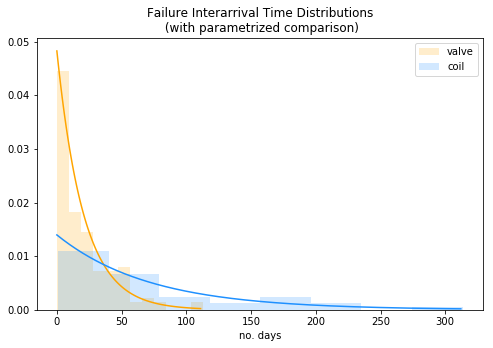

In [42]:
from scipy.stats import norm, expon
# def get_fail_iat(event_df, tag):
#     fail_time_valve = event_df[(event_df['broken']==1) & (event_df['replace']==1) & (event_df[tag]==1)]
#     fail_time_valve['date']=fail_time_valve.index
#     fail_time_valve.index = range(fail_time_valve.shape[0])
#     iat_valve = fail_time_valve['date']-fail_time_valve.shift()['date']
#     return iat_valve

def get_fail_iat(events, cond, *tags):

#     print events[events[list(tags)].all(axis=1)].shape
#     print events[cond].shape
    fail_time = events[(cond)&(events[list(tags)].all(axis=1))]
    fail_time = fail_time.assign(date = fail_time.index)
    
#     fail_time = fail_time.set_index(range(fail_time.shape[0]))
#     print fail_time.index, fail_time.shift().index
    iat = fail_time['date']-fail_time.shift()['date']
#     iat = fail_time.index - fail_time.shift().index
#     print iat
    return iat

cond = (event_df['leak']==1)&(event_df[['water', 'air']].any(axis=1))

def hist_vs_exp(events, cond, *tags, **plot_args):
    color = plot_args.get('color', 'k')
    dat = (get_fail_iat(events, cond, *tags)/ pd.Timedelta(days=1)).values[1:]
    
    plt.hist(dat, label=', '.join(tags), normed=True, bins='auto', color=color, histtype='stepfilled', alpha=.2)
    
   
    print('{} leak:\t{:.2f} days'.format(', '.join(tags), dat.mean()))
    plt.plot(range(int(max(dat.tolist()+[0]))), 
             expon(scale=dat.mean()).pdf(np.arange(int(max(dat.tolist()+[0])))),
             color=color)

plt.figure(figsize=(8,5))
plt.title('Failure Interarrival Time Distributions\n (with parametrized comparison)')
hist_vs_exp(event_df, cond, 'valve', color='orange')
# hist_vs_exp(event_df, cond, 'too_cold', color='forestgreen')
hist_vs_exp(event_df, cond, 'coil', color='dodgerblue')

plt.xlabel('no. days')
print('expected interarrival time:')
plt.grid(b=False)
plt.legend()


# plt.text(40, 0.03, r'$\delta_f(\mathrm{valve})\sim\mathrm{Exp}(26.1)$',
#          fontsize=12)
# plt.text(40, 0.02, r'$\delta_f(\mathrm{diaphragm})\sim\mathrm{Exp}(17.9)$',
#          fontsize=12)

In [43]:
df.AssetID.dropna()[df.AssetID.str.contains('ACU-').dropna()].unique()

array(['ACU-1', 'ACU-8', 'ACU-18', 'ACU-1B', 'ACU-4', 'ACU-2A', 'ACU-3',
       'ACU-10', 'ACU-11', 'ACU-1A', 'ACU-C5', 'ACU-7', 'ACU-5', 'ACU-C2',
       'ACU-26', 'ACU-30', 'ACU-6', 'ACU-9', 'ACU-2', 'ACU-12', 'ACU-B1',
       'ACU-B5', 'ACU-10A', 'ACU-19', 'ACU-A1', 'ACU-A4', 'ACU-25',
       'ACU-17', 'ACU-C3', 'ACU-A6', 'ACU-A2', 'ACU-E4', 'ACU-B4',
       'ACU-E2', 'ACU-7A', 'ACU-15', 'ACU-OCR-1', 'ACU-20', 'ACU-13',
       'ACU-14A', 'ACU-22', 'ACU-C4', 'ACU-2-GG', 'ACU-27', 'ACU-B2',
       'ACU-33', 'ACU-A15', 'ACU-14', 'ACU-16', 'ACU-4A', 'ACU-E3',
       'ACU-A5', 'ACU-B6', 'ACU-A3', 'ACU-28', 'ACU-C1', 'ACU-B7',
       'ACU-B8', 'ACU-24', 'ACU-E1', 'ACU-21', 'ACU-2C', 'ACU-6A',
       'ACU-24A', 'ACU-31', 'ACU-B3', 'ACU-6B', 'ACU-24B'], dtype=object)

In [44]:
df.dropna()[df.dropna().AssetID.str.contains('ACU-')].groupby('Building').AssetID.nunique()

Building
101    33
202     8
205     5
207     1
215     1
218     2
220    20
221    17
222     9
223    13
224    14
225    28
226    16
227     8
230     3
231     8
233     3
235    16
236     1
237     2
245    23
301    11
303     2
304     9
309     1
312     1
318     1
411     1
Name: AssetID, dtype: int64

### Parameter estimation
Below, suppose random variable ''X'' is exponentially distributed with rate parameter $\lambda$, and $x_1, \dotsc, x_n$ are ''n'' independent samples from ''X'', with sample mean $\bar{x}$.

#### Maximum likelihood
The Likelihood function for λ, given an independent identically-distributed random variables sample $x = \{x_1, \cdots, x_n\}$ drawn from the variable, is:

$$L(\lambda) = \prod_{i=1}^n \lambda \exp(-\lambda x_i) = \lambda^n \exp \left(-\lambda \sum_{i=1}^n x_i\right)=\lambda^n\exp\left(-\lambda n \overline{x}\right)$$

where:

$$\overline{x}={1 \over n}\sum_{i=1}^n x_i$$

is the sample mean.

Consequently, the maximum likelihood estimate for the rate parameter is:

$$\widehat{\lambda} = \frac{1}{\overline{x}} = \frac{n}{\sum_i x_i}$$


Although this is not an unbiased estimator of $\lambda$, $\overline{x}$ is an unbiased MLE estimator of $\frac{1}{\lambda} = \beta$ where $\beta$ is exponential dist. scale parameter


In [325]:

# cond = (event_df['leak']==1)&(event_df[['water','steam']].any(axis=1))
from scipy.stats import hmean

hsum = lambda a: a.shape[0]/a.sum()  # reciprocal of sum of reciprocals

def fail_iat(events, cond, *tags, pand=True):
    MIAT = {}
    if pand: 
        tups = []
        vals = np.array([])
        lams = []
    for bldg in tqdm_notebook(df.Building.unique(), desc='Bldg. Loop'):
        
#         acu_names = df[df.Building==bldg].AssetID.dropna()[df.AssetID.str.contains('ACU-').dropna()].unique()
        acu_names = df[df.Building==bldg].AssetID.dropna().unique()

        if acu_names.shape[0]==0:
            continue
#         MIAT[bldg] = {}

        new_cond = (cond)&\
            (og_data.Building==bldg)
    #         hist_vs_exp(event_df, cond, 'valve')
        dat = (get_fail_iat(events, new_cond, *tags)/ pd.Timedelta(weeks=1)).values[1:]
        if dat.shape[0]==0:
            continue
        MIAT[bldg] = dat
        if pand:
            tups += [(bldg, i) for i in range(dat.shape[0])]
            vals = np.append(vals,dat)
            lams += dat.shape[0]*[hsum(dat)]
#             lams += dat.shape[0]*[(1/np.median(dat)).sum()]
    if pand: 
        index = pd.MultiIndex.from_tuples(tups, names=["bldg", 'n'])
        exp_df = pd.DataFrame({'IAT':vals, 'Event Rate':lams}, index=index)
        return exp_df
    else:
        return MIAT

def machine_fail_iat(events, cond, *tags, pand=True, clip_low=0.15):
    MIAT = {}
    if pand: 
        tups = []
        vals = np.array([])
        lams = []
    for bldg in tqdm_notebook(df.Building.unique(), desc='Bldg. Loop'):
        
#         acu_names = df[df.Building==bldg].AssetID.dropna()[df.AssetID.str.contains('ACU-').dropna()].unique()
        acu_names = df[df.Building==bldg].AssetID.dropna().unique()

        if acu_names.shape[0]==0:
            continue
        MIAT[bldg] = {}
        for mID in tqdm_notebook(acu_names, 
                                 desc='Asset Loop', leave=False):
            new_cond = (cond)&\
                (og_data.Building==bldg)&\
                (og_data.AssetID==mID)
    #         hist_vs_exp(event_df, cond, 'valve')
            dat = (get_fail_iat(events, new_cond, *tags)/ pd.Timedelta(weeks=1)).values[1:]
            if dat.shape[0]==0:
                continue
            MIAT[bldg][mID] = dat
            if pand:
                tups += [(bldg, mID, i) for i in range(dat.shape[0])]
                vals = np.append(vals,dat)
                lams += dat.shape[0]*[hsum(dat.clip(min=clip_low))]
#                 lams += dat.shape[0]*[(1/np.median(dat)).sum()]
    if pand: 
        index = pd.MultiIndex.from_tuples(tups, names=["bldg", 'acu', 'n'])
        exp_df = pd.DataFrame({'IAT':vals, 'Fail Rate':lams}, index=index)
        return exp_df
    else:
        return MIAT

# cond = (event_df['leak']==1)&(event_df[['motor','coil', 'water']].any(axis=1))
# cond = (event_df['leak']==1)&(event_df[['water', 'air']].any(axis=1))

# cond = (event_df['too_hot']==1)|(event_df['too_cold']==1)
cond = event_df['leak']==1
# cond = event_df.any(axis=1)
mach_exp_df = machine_fail_iat(event_df, cond)
even_exp_df = fail_iat(event_df, cond)
# plt.legend()

/home/tbsexton/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


(0, 0.05)

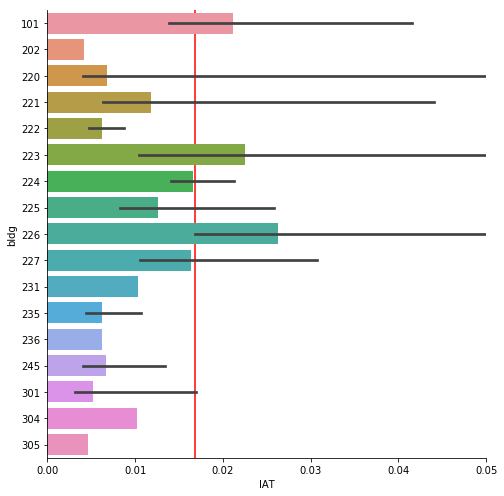

In [334]:
# plt.figure(figsize=(12,1))
exp_df = mach_exp_df.copy()
exp_df.loc[:,'IAT'] = exp_df['IAT'].clip_lower(.15) # cant be less than ~ 1 day

sns.factorplot(y='bldg', x='IAT', data=exp_df.reset_index(),
               kind='bar', aspect=1, orient='h', size=7, estimator=hsum)
plt.axvline(x=exp_df['Fail Rate'].median(), c='r', zorder=0, label='median')
plt.xlim(0,0.05)
# plt.xscale('log')

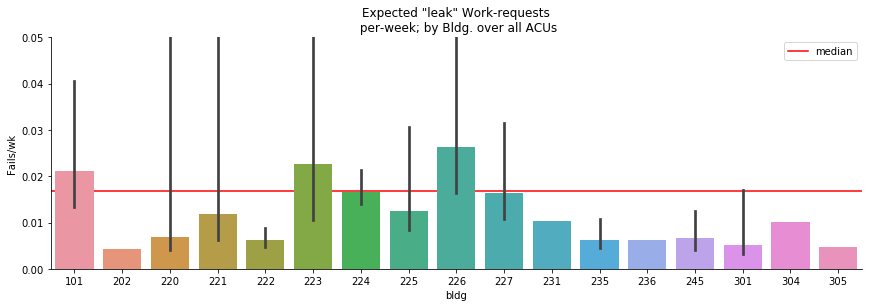

In [350]:
sns.factorplot(x='bldg', y='IAT', data=exp_df.reset_index(),
               kind='bar', aspect=3, estimator=hsum)
# plt.yscale('log')
plt.axhline(y=exp_df['Fail Rate'].median(), c='r', zorder=0, label='median')
plt.title('Expected "leak" Work-requests\n per-week; by Bldg. over all ACUs')
plt.ylim(0,0.05)
plt.ylabel('Fails/wk')
plt.legend()

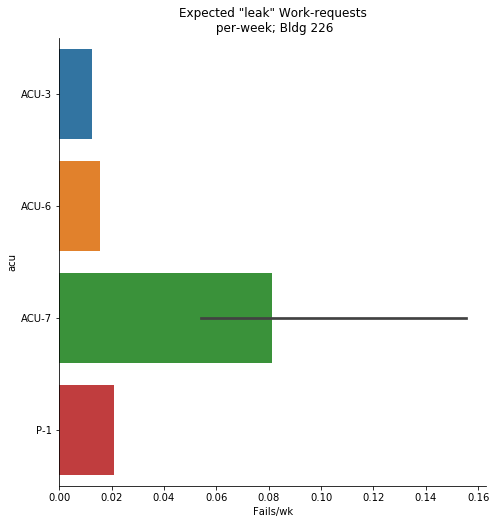

In [349]:
sns.factorplot(y='acu', x='IAT', data=exp_df.loc['226'].reset_index(),
               kind='bar', size=7,aspect=1, sharex=False, orient='h', estimator=hsum)
plt.title('Expected "leak" Work-requests\n per-week; Bldg 226')

plt.xlabel('Fails/wk')

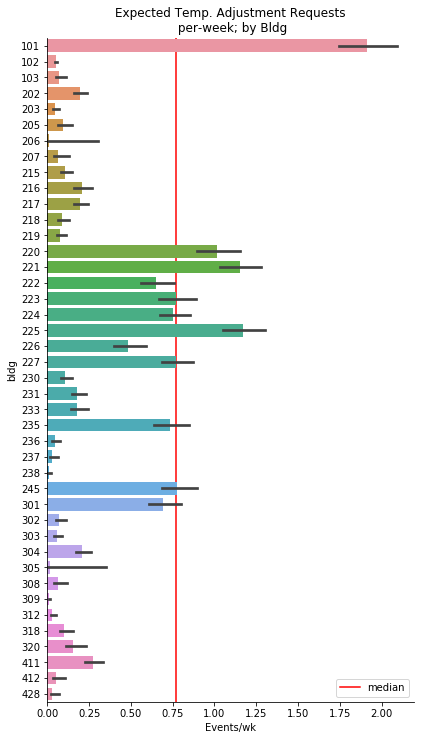

In [273]:
cond = (event_df['too_hot']==1)|(event_df['too_cold']==1)
# cond = event_df.any(axis=1)
exp_df = fail_iat(event_df, cond)
# sns.factorplot(y='bldg', x='IAT', data=exp_df.reset_index(),
#                kind='point', aspect=.6, estimator=hsum, orient='h', size=10, join=False)
sns.factorplot(y='bldg', x='IAT', data=exp_df.reset_index(),
               kind='bar', aspect=.6, estimator=hsum, orient='h', size=10)
# plt.yscale('log')
plt.axvline(x=exp_df['Event Rate'].median(), c='r', zorder=0, label='median')
plt.title('Expected Temp. Adjustment Requests\n per-week; by Bldg')
plt.legend()
plt.xlabel('Events/wk')

## Taxonomy

In [135]:
itm_relevant = get_relevant(df_pred, 'Items', topn=500)
itm_event = pd.DataFrame(columns = [i[0] for i in itm_relevant if i[0]!=u''], 
             data = np.array([i[2] for i in itm_relevant if i[0]!=u'']).T)


In [136]:
coocc = itm_event.T.dot(itm_event)
occ = np.diagonal(np.copy(coocc))

np.fill_diagonal(coocc.values, 0)
coocc.head()


,room,poc,temperature,building,thermostat,unit,air_conditioning_unit,air,customer,valve,...,moisture,housing,fitting,drill,bolt,wiring,heat_pump,battery,oil,coupling
room,0,993,1532,1070,873,415,378,401,518,439,...,5,2,3,3,2,3,3,2,0,4
poc,993,0,564,617,705,364,329,347,840,291,...,3,3,1,0,3,1,5,2,1,2
temperature,1532,564,0,1116,487,233,212,225,306,193,...,3,1,1,1,0,0,1,4,0,0
building,1070,617,1116,0,450,268,217,230,292,204,...,2,1,3,2,3,0,4,0,1,1
thermostat,873,705,487,450,0,188,167,248,293,257,...,0,0,2,1,0,1,2,2,0,0


In [137]:
dist_mat = coocc/np.dot(np.sqrt(occ).T, np.sqrt(occ))

dist_mat.head()

,room,poc,temperature,building,thermostat,unit,air_conditioning_unit,air,customer,valve,...,moisture,housing,fitting,drill,bolt,wiring,heat_pump,battery,oil,coupling
room,0.000000,0.015543,0.023980,0.016749,0.013665,0.006496,0.005917,0.006277,0.008108,0.006872,...,0.000078,0.000031,0.000047,0.000047,0.000031,0.000047,0.000047,0.000031,0.000000,0.000063
poc,0.015543,0.000000,0.008828,0.009658,0.011035,0.005698,0.005150,0.005432,0.013148,0.004555,...,0.000047,0.000047,0.000016,0.000000,0.000047,0.000016,0.000078,0.000031,0.000016,0.000031
temperature,0.023980,0.008828,0.000000,0.017469,0.007623,0.003647,0.003318,0.003522,0.004790,0.003021,...,0.000047,0.000016,0.000016,0.000016,0.000000,0.000000,0.000016,0.000063,0.000000,0.000000
building,0.016749,0.009658,0.017469,0.000000,0.007044,0.004195,0.003397,0.003600,0.004571,0.003193,...,0.000031,0.000016,0.000047,0.000031,0.000047,0.000000,0.000063,0.000000,0.000016,0.000016
thermostat,0.013665,0.011035,0.007623,0.007044,0.000000,0.002943,0.002614,0.003882,0.004586,0.004023,...,0.000000,0.000000,0.000031,0.000016,0.000000,0.000016,0.000031,0.000031,0.000000,0.000000


In [138]:
import networkx as nx

G = nx.from_numpy_matrix(dist_mat.values)
G = nx.relabel_nodes(G, dict(zip(G.nodes(), dist_mat.columns)))

In [139]:
cent = pd.Series(nx.pagerank(G))
cent.sort_values(ascending=False).iloc[:10].index.values

array(['room', 'poc', 'temperature', 'building', 'unit', 'thermostat',
       'air', 'customer', 'air_conditioning_unit', 'valve'], dtype=object)

In [140]:
def heymann_taxonomy(dist_mat, cent_prog='pr', tau=5e-4, 
                     dynamic=False, dotfile=None, verbose=False):
    """
    dist_mat: dataframe containing similarity matrix, indexed and named by tags
    cent_prog: algorithm to use in calculating node centrality
        pr: PageRank
        eig: eigencentrality
        btw: betweenness
        cls: closeness
    tau: similarity threshold for retaining a node
    dynamic: re-calculate centrality after adding every tag
    write_dot: fname or None, where to save a .dot, if any. 
    verbose: print some stuff
    """
#     tau = 5e-4
    cent_dict = {
        'pr': nx.pagerank,
        'eig': nx.eigenvector_centrality,
        'btw': nx.betweenness_centrality,
        'cls': nx.closeness_centrality
    }
    
    # Create the co-occurence graph, G
    G = nx.from_numpy_matrix(dist_mat.values)
    G = nx.relabel_nodes(G, dict(zip(G.nodes(), dist_mat.columns)))
    
    # Calculate the centrality of nodes in G
    cent = pd.Series(cent_dict[cent_prog](G)).sort_values(ascending=False)
    root = cent.index[0]
    
    # Init the taxonomy D (DAG)
    D = nx.DiGraph()
    D.add_node(root)

    for n in tqdm_notebook(range(dist_mat.shape[0])):
        
        # Pick the most central node in G, and the node in D most similar to it
        tag = cent.index[0]
        neighbor_sim =  {k: dist_mat.loc[tag,k] for k in D.nodes()}
        parent = max(neighbor_sim, key=lambda key: neighbor_sim[key])
        
        if neighbor_sim[parent] > tau:
            # above threshold--> direct child
            D.add_node(tag)
            D.add_edge(parent, tag)
        else:
    #         D.add_edge(root, descendant)  # do not enforce single taxonomy
            # New "top-level" tag
            D.add_node(tag)
            pass
        
        if dynamic:
            # recalculate node centralities after removing each <tag>
            # EXPENSIVE.
            G.remove_node(tag)
            cent = pd.Series(cent_dict[cent_prog](G)).sort_values(ascending=False)
        else:
            cent.drop(tag, inplace=True)
    
    if verbose:
        print(root) # most "general" topic
        print(nx.isolates(D)) # child-less nodes (i.e. central AND dissimilar)
    
    
    D.remove_nodes_from(nx.isolates(D))  # not useful for taxonomy
    
    if dotfile is not None:
        from networkx.drawing.nx_pydot import graphviz_layout, write_dot
        D.graph['graph']={'rankdir':'LR', 'splines':'true', 
                          'ranksep':'4'}
        write_dot(D, dotfile)
    
    return D

D = heymann_taxonomy(dist_mat, 
                     cent_prog='pr', # dynamic=True,
                     dotfile='tax_hvac.dot')

In [141]:
!dot -Tpng tax_hvac.dot >tax_hvac.png

<img src="tax.png" alt="tax.png" style="height: 1200px;"/>

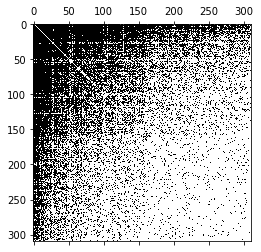

In [143]:
plt.spy(coocc.values)

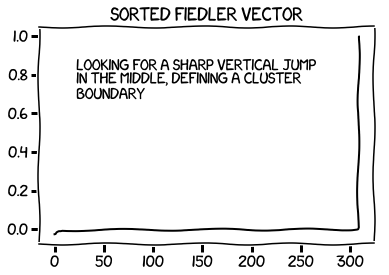

In [145]:
import matplotlib
matplotlib.font_manager._rebuild()

with plt.xkcd():
    plt.title('sorted fiedler vector')
    fied = nx.fiedler_vector(G)
    plt.plot(np.arange(fied.shape[0]),np.sort(nx.fiedler_vector(G)), 'k')
    # place a text box in upper left in axes coords
    plt.text(0.1, 0.85, ' Looking for a sharp vertical jump\n in the middle, defining a cluster\n boundary',
             transform=plt.gca().transAxes, fontsize=14, verticalalignment='top'
            )

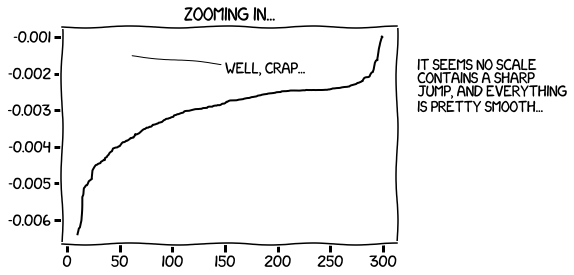

In [146]:
with plt.xkcd():
    plt.title('zooming in...')
    fied = nx.fiedler_vector(G)
    plt.plot(np.arange(fied.shape[0])[10:-10],np.sort(fied)[10:-10], 'k')
    plt.annotate(
        'well, crap...',
        xy=(60,-.0015), arrowprops=dict(arrowstyle='-'), xytext=(150, -.002)
    )
    plt.text(1.05, 0.85, ' It seems no scale\n contains a sharp\n jump, and everything\n is pretty smooth...',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top'
        )

In [147]:
nx.spectral_ordering(G, weight=None)

['coupling',
 'damper_door',
 'freon',
 'oil',
 'dielectric',
 'freezer',
 'baseboard',
 'battery',
 'booster_unit',
 'paint',
 'acu-15',
 'deflector',
 'glycol',
 '66F',
 '90F',
 'riser',
 'regulator',
 'knob',
 'sheaf',
 'evaporator',
 'condensor',
 'wiring',
 'fan_section',
 'water_valve',
 'bolt',
 'library',
 'refrigerator',
 'ahu-1',
 'detection',
 'cable',
 'fitting',
 'spring',
 'frame',
 'director',
 'probe',
 'drain_line',
 '57F',
 'drill',
 'condenser',
 'penthouse',
 '58F',
 'transducer',
 '320',
 'boiler',
 'acu-16',
 '75F',
 '78F',
 '76F',
 '55F',
 '65F',
 'store_room',
 'alignment',
 '2F',
 'air_filter',
 '411',
 '236',
 'head',
 'converter',
 'acu-19',
 'humidifier',
 'humidity_sensor',
 'acu-17',
 'carpet',
 'water_detection',
 'defuser',
 'lobby',
 'air_compressor',
 'tank',
 'wing',
 '62F',
 'entrance',
 'storeroom',
 '67F',
 'bearing',
 'heat_pump',
 'cafeteria',
 'grease',
 '74F',
 'east',
 'detector',
 '69F',
 'moisture',
 'middle',
 'return_fan',
 'piping',
 'sta

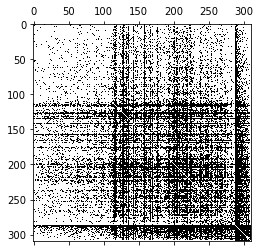

In [148]:
plt.spy(coocc.loc[nx.spectral_ordering(G, weight=None),
                  nx.spectral_ordering(G, weight=None)])

In [157]:
from networkx.readwrite import json_graph
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import json

subD = dfs_tree(D, 'room')

with open('d3tree.json', 'w') as outfile:
    s=json.dump(json_graph.tree.tree_data(subD, 'room'), outfile)

In [158]:
%%writefile f2.template
<!DOCTYPE html>
<meta charset="utf-8">
<style>

.node {
  cursor: pointer;
}

.node circle {
  fill: #fff;
  stroke: steelblue;
  stroke-width: 1.5px;
}

.node text {
  font: 10px sans-serif;
}

.link {
  fill: none;
  stroke: #ccc;
  stroke-width: 1.5px;
}

</style>
<body>
<script src="//d3js.org/d3.v3.min.js"></script>
<script>

var margin = {top: 20, right: 120, bottom: 20, left: 120},
    width = 1500 - margin.right - margin.left,
    height = 1200 - margin.top - margin.bottom;

var i = 0,
    duration = 750,
    root;

var tree = d3.layout.tree()
    .size([height, width]);

var diagonal = d3.svg.diagonal()
    .projection(function(d) { return [d.y, d.x]; });

var svg = d3.select("body").append("svg")
    .attr("width", width + margin.right + margin.left)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

d3.json("d3tree.json", function(error, flare) {
  if (error) throw error;

  root = flare;
  root.x0 = height / 2;
  root.y0 = 0;

  function collapse(d) {
    if (d.children) {
      d._children = d.children;
      d._children.forEach(collapse);
      d.children = null;
    }
  }

  root.children.forEach(collapse);
  update(root);
});

d3.select(self.frameElement).style("height", "1200px");

function update(source) {

  // Compute the new tree layout.
  var nodes = tree.nodes(root).reverse(),
      links = tree.links(nodes);

  // Normalize for fixed-depth.
  nodes.forEach(function(d) { d.y = d.depth * 180; });

  // Update the nodes…
  var node = svg.selectAll("g.node")
      .data(nodes, function(d) { return d.id || (d.id = ++i); });

  // Enter any new nodes at the parent's previous position.
  var nodeEnter = node.enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + source.y0 + "," + source.x0 + ")"; })
      .on("click", click);

  nodeEnter.append("circle")
      .attr("r", 1e-6)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeEnter.append("text")
      .attr("x", function(d) { return d.children || d._children ? -10 : 10; })
      .attr("dy", ".35em")
      .attr("text-anchor", function(d) { return d.children || d._children ? "end" : "start"; })
      .text(function(d) { return d.id; })
      .style("fill-opacity", 1e-6);

  // Transition nodes to their new position.
  var nodeUpdate = node.transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + d.y + "," + d.x + ")"; });

  nodeUpdate.select("circle")
      .attr("r", 4.5)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeUpdate.select("text")
      .style("fill-opacity", 1);

  // Transition exiting nodes to the parent's new position.
  var nodeExit = node.exit().transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + source.y + "," + source.x + ")"; })
      .remove();

  nodeExit.select("circle")
      .attr("r", 1e-6);

  nodeExit.select("text")
      .style("fill-opacity", 1e-6);

  // Update the links…
  var link = svg.selectAll("path.link")
      .data(links, function(d) { return d.target.id; });

  // Enter any new links at the parent's previous position.
  link.enter().insert("path", "g")
      .attr("class", "link")
      .attr("d", function(d) {
        var o = {x: source.x0, y: source.y0};
        return diagonal({source: o, target: o});
      });

  // Transition links to their new position.
  link.transition()
      .duration(duration)
      .attr("d", diagonal);

  // Transition exiting nodes to the parent's new position.
  link.exit().transition()
      .duration(duration)
      .attr("d", function(d) {
        var o = {x: source.x, y: source.y};
        return diagonal({source: o, target: o});
      })
      .remove();

  // Stash the old positions for transition.
  nodes.forEach(function(d) {
    d.x0 = d.x;
    d.y0 = d.y;
  });
}

// Toggle children on click.
function click(d) {
  if (d.children) {
    d._children = d.children;
    d.children = null;
  } else {
    d.children = d._children;
    d._children = null;
  }
  update(d);
}

</script>

Overwriting f2.template


In [159]:
from IPython.display import IFrame
import re

def replace_all(txt,d):
    rep = dict((re.escape('{'+k+'}'), str(v)) for k, v in d.items())
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], txt)    

count=0
def serve_html(s,w,h):
    import os
    global count
    count+=1
    fn= '__tmp'+str(os.getpid())+'_'+str(count)+'.html'
    with open(fn,'w') as f:
        f.write(s)
    return IFrame('files/'+fn,w,h)

def f2(w=500,h=400):
    d={
       'width'      :w,
       'height'     :h,
       }
    with open('f2.template','r') as f:
        s=f.read()
    s= replace_all(s,d)        
    return serve_html(s,w+30,h+30)

In [160]:
f2(w=1500,h=1200)